In [1]:
import pandas as pd
import numpy as np
import datetime
import statsmodels as sm
import matplotlib.pyplot as plt
import seaborn as sns 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
import matplotlib
import folium
import warnings
import matplotlib.ticker as ticker
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
%matplotlib inline

In [2]:
df_raw = pd.read_csv('data/mn_ev_registrations_public.csv')

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
years = pd.DataFrame(df_raw['Registration Valid Date'].value_counts().reset_index().values, columns=["Year", "Registered Vehicles"])

,Registered Vehicles
Year,
2008-03-04,6.0
2008-04-24,5.0
2008-08-18,3.0
2008-08-19,12.0
2008-08-25,3.0
...,...
2022-04-05,117.0
2022-04-06,103.0
2022-04-07,69.0


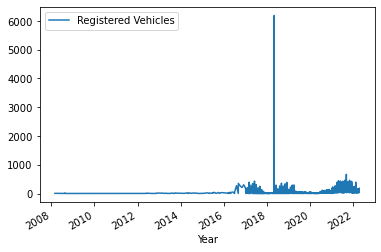

In [4]:
df = pd.DataFrame(years['Registered Vehicles'])
df = df.set_axis(pd.to_datetime(years['Year']))
df.plot()
df = df.sort_values(by=['Year'], ascending = True)
df = df.astype(float)
df

## **RESAMPLING

In [5]:
# # Interpolate - Backfill 
# df = df.resample('W').interpolate(method = 'linear')
# df = df.bfill()
# print(df.head())
# df.plot()

In [6]:
# # Backfill 
# df = df.resample('W').bfill()
# df.plot()

<AxesSubplot:xlabel='Year'>

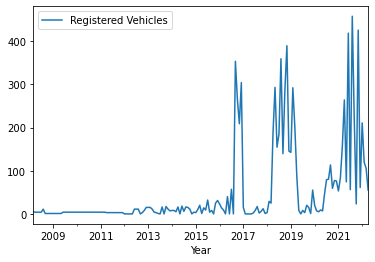

In [7]:
# #Frontfill 
df = df.resample('M').ffill()
df.plot()

## Testing 

In [8]:
adtest = adfuller(df)
display(adtest)

(-3.3532279714263025,
 0.012660492239594175,
 7,
 162,
 {'1%': -3.471374345647024,
  '5%': -2.8795521079291966,
  '10%': -2.5763733302850174},
 1761.4530673311915)

## Modeling

In [16]:
# Splitting Training and Testing data; using after 2019 as test

train = df[:'2019-12']
test = df['2021':]
combined = df

test

,Registered Vehicles
Year,
2021-01-31,54.0
2021-02-28,84.0
2021-03-31,158.0
2021-04-30,264.0
2021-05-31,75.0
2021-06-30,418.0
2021-07-31,57.0
2021-08-31,457.0
2021-09-30,219.0


In [17]:
auto_model = pm.auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=6, max_q=6,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)
print(auto_model.summary())



Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1675.396, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1555.966, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1594.966, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1552.009, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=1543.491, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1532.767, Time=0.08 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=1534.714, Time=0.10 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=1534.727, Time=0.11 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1536.649, Time=0.09 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=1536.432, Time=0.25 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1531.631, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1543.729, Time=0.15 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=1533.629, Time=0.18 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=1533.629, Time=0.23 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept

### The best model is :  ARIMA (4, 0, 0) (0,0,0) [0]

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6304      0.059     10.642      0.000       0.514       0.747
ar.L2          0.0524      0.060      0.877      0.380      -0.065       0.170
ar.L3          0.4349      0.056      7.761      0.000       0.325       0.545
ar.L4         -0.2978      0.063     -4.719      0.000      -0.421      -0.174
sigma2      2707.1465    109.973     24.616      0.000    2491.603    2922.690


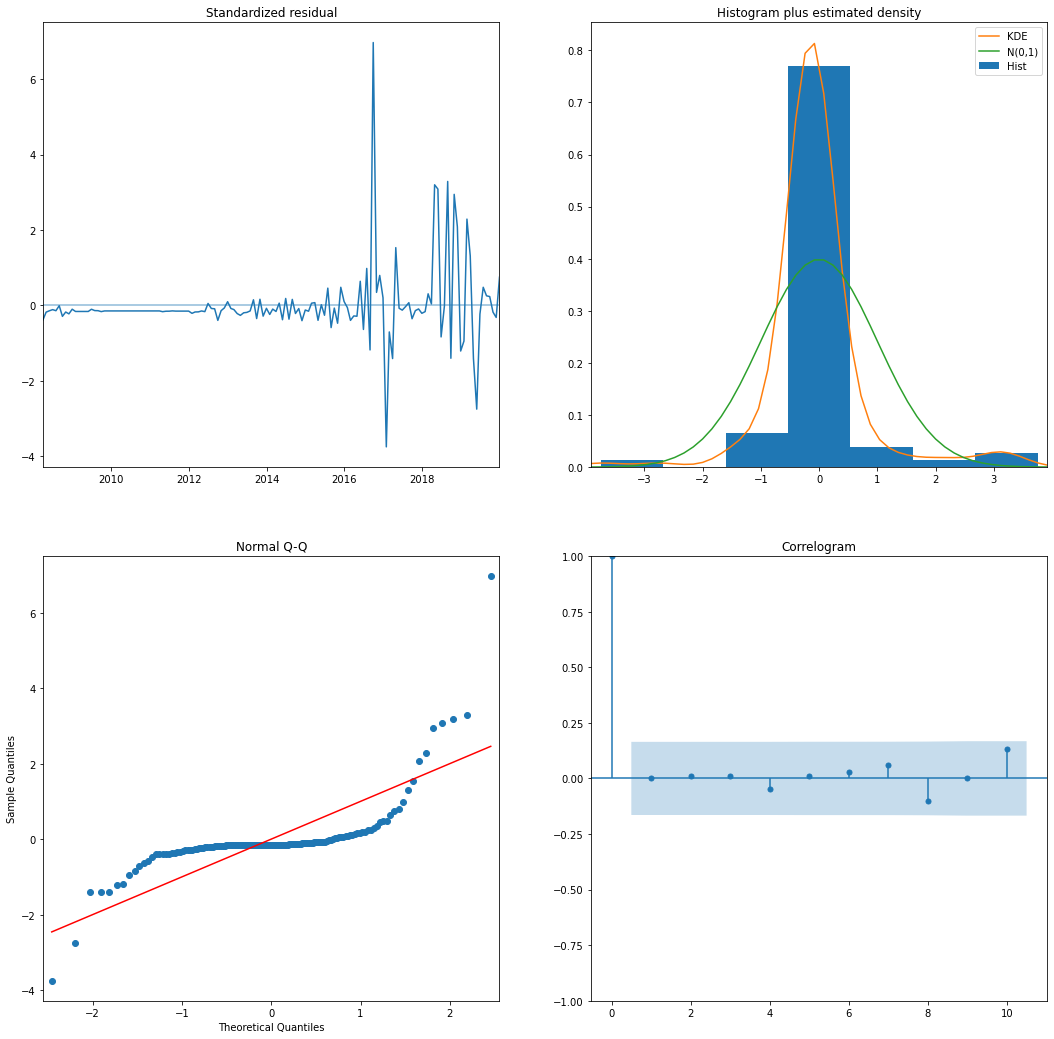

In [18]:
ARIMA_MODEL = sm.tsa.statespace.sarimax.SARIMAX(train, 
                                        order=(4,0,0), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)


output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [ ]:
2021-01-31	54.0
2021-02-28	84.0
2021-03-31	158.0
2021-04-30	264.0
2021-05-31	75.0
2021-06-30	418.0
2021-07-31	57.0
2021-08-31	457.0
2021-09-30	219.0
2021-10-31	24.0
2021-11-30	425.0
2021-12-31	62.0
2022-01-31	211.0
2022-02-28	120.0
2022-03-31	106.0
2022-04-30	56.0


In [19]:
pred = output.get_prediction(start=pd.to_datetime('2021-01-31'), end=pd.to_datetime('2022-04-30'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower Registered Vehicles,upper Registered Vehicles
2021-01-31,-170.434014,177.919454
2021-02-28,-171.547973,177.136363
2021-03-31,-171.495451,177.390515
2021-04-30,-172.680172,176.407793
2021-05-31,-173.155295,176.015455
2021-06-30,-173.162625,176.060544
2021-07-31,-173.714846,175.557232
2021-08-31,-173.922648,175.369801
2021-09-30,-173.944199,175.361581
2021-10-31,-174.204932,175.112569


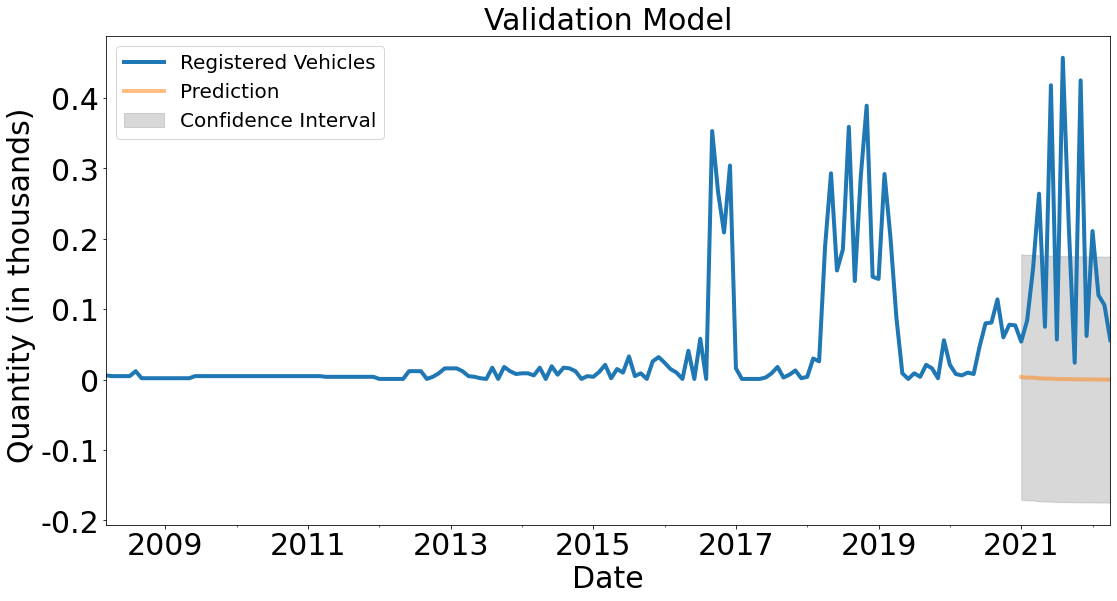

In [20]:


rcParams['figure.figsize'] = 18, 9
ax = df.plot(label='observed', linewidth = 4)

pred.predicted_mean.plot(ax=ax, label='Prediction', alpha=0.5, linewidth = 4)


ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='grey', alpha=0.3,label = 'Confidence Interval')


ax.set_xlabel('Date',fontsize=30)
plt.xticks(fontsize=30)
ax.set_ylabel('Quantity (in thousands) ',fontsize=30)
plt.yticks(fontsize=30)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.set_title('Validation Model',fontsize=30)
plt.legend(fontsize = 20)

plt.show()